# AWS Saas Customer Segmentation and Discount Analysis

by Rahmawati Annisa Salsadilla

## Background

Amazon Web Services (AWS) adalah penyedia layanan komputasi awan terkemuka yang menawarkan berbagai produk dalam bentuk layanan cloud. Dalam ranah Software as a Service (SaaS) khusus untuk tools penjualan dan pemasaran B2B, AWS telah mengumpulkan data transaksi selama empat tahun terakhir. Keunggulan kompetitif utama AWS terletak pada kemampuannya membantu perusahaan menghemat biaya sambil memaksimalkan kebutuhan bisnis. Hal ini didorong oleh model "Pay less by using more", di mana penggunaan layanan yang lebih tinggi menghasilkan manfaat biaya, dan "Bundled Discounts", yang memberikan diskon atau produk gratis berdasarkan penggunaan layanan lain.

Selain itu, AWS mengatasi tantangan ketidakpastian penggunaan dalam model industri "Pay As You Go" dengan menawarkan Savings Plan. Berbeda dengan kompetitor yang seringkali menyebabkan kerugian jika penggunaan layanan tidak sesuai dengan prediksi, Savings Plan memungkinkan pelanggan merencanakan pengeluaran minimum selama satu hingga tiga tahun ke depan dan berkomitmen pada jumlah pengeluaran per jam tertentu. Model diskon ini tidak hanya memudahkan pelanggan dalam merencanakan kapasitas dan menghemat uang, tetapi juga secara strategis mempersulit mereka untuk beralih ke layanan pesaing, memperkuat posisi pasar AWS.

## Problem Statement

**Perusahaan ingin memahami bagaimana berbagai besaran diskon mempengaruhi sales dan profit**. Oleh karenanya analisis ini akan mengelompokan pelanggan ke dalam segmen menggunakan rentang interquartile sales dimana:
- kuartil dibawah 25% masuk kedalam segmen low sales,
- kuartil antara 25% - 75% masuk kedalam segmen medium sales,
- kuartil diatas 75% masuk kedalam high sales.

Dari segmen tersebut kita akan menganalisis berapa ambang batas diskon yang ideal dapat menaikan sales tetapi tidak menurunkan profit sampai negatif. Informasi ini akan membantu perusahaan mengembangkan strategi diskon untuk meningkatkan sales dan profit kepada pelanggan di segmen medium sales dan low sales.

Dalam analisis ini, kita akan mencoba menjawab pertanyaan berikut:

1. Pelanggan mana saja yang dikategorikan sebagai high, medium, dan low sales?
2. Bagaimana berbagai besaran diskon mempengaruhi penjualan dan keuntungan pada setiap kategori pelanggan?

## Goals

Dengan mengidentifikasi segmen pelanggan dan menganalisis besaran diskon yang ideal, dapat membantu perusahaan merumuskan strategi diskon yang lebih tepat sasaran untuk mengoptimumkan sales dan profit, khususnya untuk segmen pelanggan yang berada di kategori medium dan low sales.

## Data Understanding

Sebelum masuk ke dalam analisis kita perlu memahami karakteristik data terlebih dahulu. Dari sini kita dapat melihat anomali-anomali apa saja yang terdapat di dalam dataset kita dan perlu ditangani dalam tahapan data cleaning. Setiap penangan anomali yang dilakukan akan disertai dengan justifikasi langkah yang diambil, baik secara domain knowledge maupun secara statistik. Setelah itu kita akan melihat secara visualisasi bagaimana pusat tendensi, persebaran dan hubungan pada kolom-kolom data.

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Import Data AWS Saas Sales
from google.colab import files
uploaded = files.upload()
df = pd.read_csv("SaaS-Sales.csv")

# Menampilkan Informasi Data
df.info()

Saving SaaS-Sales.csv to SaaS-Sales (1).csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Row ID        9994 non-null   int64  
 1   Order ID      9994 non-null   object 
 2   Order Date    9994 non-null   object 
 3   Date Key      9994 non-null   int64  
 4   Contact Name  9994 non-null   object 
 5   Country       9994 non-null   object 
 6   City          9994 non-null   object 
 7   Region        9994 non-null   object 
 8   Subregion     9994 non-null   object 
 9   Customer      9994 non-null   object 
 10  Customer ID   9994 non-null   int64  
 11  Industry      9994 non-null   object 
 12  Segment       9994 non-null   object 
 13  Product       9994 non-null   object 
 14  License       9994 non-null   object 
 15  Sales         9994 non-null   float64
 16  Quantity      9994 non-null   int64  
 17  Discount      9994 non-null

Dataset ini secara garis besar berisi informasi tentang transaksi, data pelanggan, lokasi geografis, kategori bisnis, dan data penjualan. Ada 19 kolom dan 9994 baris.

In [3]:
# Menampilkan Statistik Deskriptif
display(df[['Sales', 'Quantity', 'Discount', 'Profit']].describe(),
        df.describe(include='object'))

,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000
mean,229.858001,3.789574,0.156203,28.656896
std,623.245101,2.225110,0.206452,234.260108
min,0.444000,1.000000,0.000000,-6599.978000
25%,17.280000,2.000000,0.000000,1.728750
50%,54.490000,3.000000,0.200000,8.666500
75%,209.940000,5.000000,0.200000,29.364000
max,22638.480000,14.000000,0.800000,8399.976000


,Order ID,Order Date,Contact Name,Country,City,Region,Subregion,Customer,Industry,Segment,Product,License
count,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994
unique,5009,1237,793,48,262,3,12,99,10,3,14,9994
top,EMEA-2023-100111,9/6/2022,Leonard Kelly,United States,London,EMEA,NAMER,Allianz,Finance,SMB,ContactMatcher,3NTBV9B3PS
freq,14,38,37,2001,922,4219,2507,192,2127,5191,1842,1


Dilihat dari statistik deskriptif kita bisa ambil kesimpulan:

1. Sales paling kecil USD 0.444 dan paling besar USD 22638.4, dengan rata-rata USD 229.8 menunjukkan bahwa sales berpusat direntang angka yang kecil, tapi terdapat beberapa sales yang tinggi.
2. Kuantitas paling kecil 1 dan paling besar 14, dengan rata-rata 3 pembelian produk menunjukkan kebanyakan pelanggan membeli produk dengan jumlah sedikit, tapi beberapa pelanggan ada yang membeli banyak. Kita akan menganalisis lebih jauh kelompok pelanggan yang membeli banyak produk.
3. Banyak pelanggan tidak menggunakan diskon tapi pelanggan antara kuartil 50% sampai 75% menggunakan diskon sebesar 0.2, dengan diskon paling besar 0.8. Kita akan lihat bagaimana besaran diskon yang digunakan pelanggan mempengaruhi kinerja sales dan profit.
4. Profit paling kecil USD -6599.9 kemungkinan ini adalah pelanggan yang menggunakan diskon besar. Profit paling besar USD 8399.9 dan rata-rata USD 28.6 menunjukkan kinerja profit yang kemungkinan stagnan.
5. Pelanggan perusahaan yang paling loyal adalah Allianz dengan frekuensi pemesanan produk sebanyak 192 kali. italicized text
6. Industri yang paling menguntungkan dari sektor keuangan dengan pemesanan produk sebanyak 2127.
7. Segmen perusahaan yang paling banyak memesan produk dari segmen UMKM (SMB) sebanyak 5191 kali.
8. Produk yang paling laku terjual adalah ContactMatcher sebanyak 1842 kali.

In [9]:
# Membuat tabel untuk menampilkan seluruh nilai unik pada kolom Industry, Segment, dan Product
pd.set_option('display.max_colwidth', 1)

nilai_unik = {
    'Daftar Industri': [df['Industry'].unique()],
    'Daftar Segmen Bisnis': [df['Segment'].unique()],
    'Daftar Produk': [df['Product'].unique()],
    'Berapa Saja Jumlah Pembelian': [df['Quantity'].unique()],
    'Berapa Saja Diskon': [df['Discount'].unique()]
} # Membuat dictionary dengan value berupa array dari nilai unik kolom

tabel_nilai_unik = pd.DataFrame(nilai_unik) # Menjadikan dictionary menjadi dataframe dengan kolomnya menggunakan key dan barisnya menggunakan value

tabel_nilai_unik

,Daftar Industri,Daftar Segmen Bisnis,Daftar Produk,Berapa Saja Jumlah Pembelian,Berapa Saja Diskon
0,"[Energy, Finance, Tech, Healthcare, Manufacturing, Retail, Consumer Products, Misc, Transportation, Communications]","[SMB, Strategic, Enterprise]","[Marketing Suite, FinanceHub, ContactMatcher, Marketing Suite - Gold, SaaS Connector Pack, ChatBot Plugin, Site Analytics, OneView, Support, Data Smasher, SaaS Connector Pack - Gold, Storage, Big Ol Database, Alchemy]","[2, 3, 5, 7, 4, 6, 9, 1, 8, 14, 11, 13, 10, 12]","[0.0, 0.45, 0.2, 0.8, 0.3, 0.5, 0.7, 0.6, 0.32, 0.1, 0.4, 0.15]"


Tujuan kita menampilkan tabel unik dari setiap data kategorik nominal (Daftar Industri, Daftar Segmen Bisnis, dan Daftar Produk) dan ordinal (Kuantitas dan Diskon) untuk memastikan tidak ada data yang salah ketik atau ambigu.

Berdasarkan tabel unik di atas tidak ada data yang salah ketik atau ambigu.

In [10]:
# Menampilkan periode transaksi
df['Order Date'] = pd.to_datetime(df['Order Date'])
display(df['Order Date'].min(), df['Order Date'].max())
customer_first_transaction = df.groupby('Customer')['Order Date'].min().reset_index()
customer_first_transaction['Order Date'].dt.year.unique()

Timestamp('2020-01-04 00:00:00')

Timestamp('2023-12-31 00:00:00')

array([2020], dtype=int32)

Berdasarkan infromasi di atas:
1. Transaksi data pertama kali bulan Januari tahun 2020 dan terakhir kali bulan Desember tahun 2023.
2. Semua pelanggan di dataset ini pertama kali melakukan transaksi tahun 2020.

## Data Cleaning

Setelah memahami karakteristik data, pada bagian ini kita melakukan pembersihan data mulai dari melihat apakah ada data yang kosong, jika ada maka akan ditangani sesuai kaidah statistik ataupun domain knowledge. Setelah itu mengubah tipe data pada kolom yang sesuai dengan konteks datanya, terakhir kita akan menghapus fitur atau kolom data yang tidak relevan dengan tujuan analisis.

Kita tidak perlu menangani nilai ekstrim atau outlier karena dalam konteks bisnis dan data ini kita membutuhkan semua data.

In [11]:
# Menampilkan presentase data yang kosong pada setiap kolom
df.isna().sum()/df.shape[0]*100

,0
Row ID,0.0
Order ID,0.0
Order Date,0.0
Date Key,0.0
Contact Name,0.0
Country,0.0
City,0.0
Region,0.0
Subregion,0.0
Customer,0.0


Berdasarkan informasi di atas tidak terdapat data yang kosong sehingga kita bisa lanjut ke tahap selanjutnya yaitu menghapus kolom yang tidak relevan dengan tujuan analisis dan mengubah tipe data yang sesuai.

In [12]:
df.drop(['Row ID', 'Date Key'], axis=1, inplace=True) # Menghapus kolom data yang tidak relevan dengan tujuan analisis
df['Customer ID'] = df['Customer ID'].astype(str) # Mengubah tipe data Customer ID menjadi object agar menghindari operasi matematika
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Order ID      9994 non-null   object        
 1   Order Date    9994 non-null   datetime64[ns]
 2   Contact Name  9994 non-null   object        
 3   Country       9994 non-null   object        
 4   City          9994 non-null   object        
 5   Region        9994 non-null   object        
 6   Subregion     9994 non-null   object        
 7   Customer      9994 non-null   object        
 8   Customer ID   9994 non-null   object        
 9   Industry      9994 non-null   object        
 10  Segment       9994 non-null   object        
 11  Product       9994 non-null   object        
 12  License       9994 non-null   object        
 13  Sales         9994 non-null   float64       
 14  Quantity      9994 non-null   int64         
 15  Discount      9994 non-null   float64 

Kita sudah dapatkan data yang bersih dengan 17 kolom beserta tipe data yang sesuai.

## Data Visualization

Sebelum analisis lebih dalam kita lihat gambaran besarnya secara visual, mari kita lihat satu persatu.

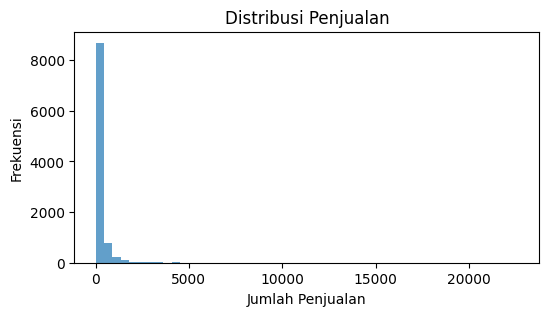

In [16]:
import matplotlib.pyplot as plt

# distribusi sales
plt.figure(figsize=(6, 3))
plt.hist(df['Sales'], bins=50, alpha=0.7)
plt.title('Distribusi Penjualan')
plt.xlabel('Jumlah Penjualan')
plt.ylabel('Frekuensi')
plt.show()

Berdasarkan diagram sales/penjualan menunjukkan sebagian besar transaksi berada di kisaran nilai sales yang lebih rendah, dengan beberapa transaksi bernilai tinggi.

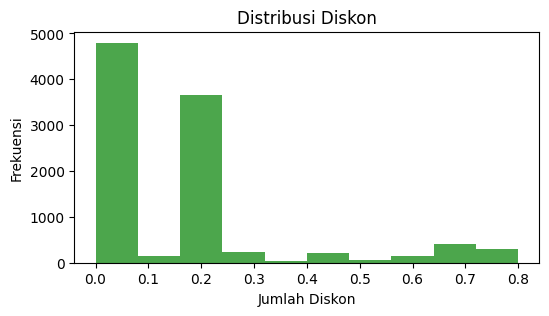

In [17]:
# Distribusi pemberian diskon
plt.figure(figsize=(6, 3))
plt.hist(df['Discount'], alpha=0.7, color='green')
plt.title('Distribusi Diskon')
plt.xlabel('Jumlah Diskon')
plt.ylabel('Frekuensi')
plt.show()

Berdasarkan diagram pemberian diskon menunjukan banyak pelanggan tidak menggunakan diskon, sebagian menggunakan diskon sebesar 20%, sisanya terdapat pelanggan yang menggunakan diskon besar. Kita akan mencari tahu pola pemberian diskon yang kecil dan besar ini lalu bagaimana besaran diskon mempengaruhi sales dan profit.

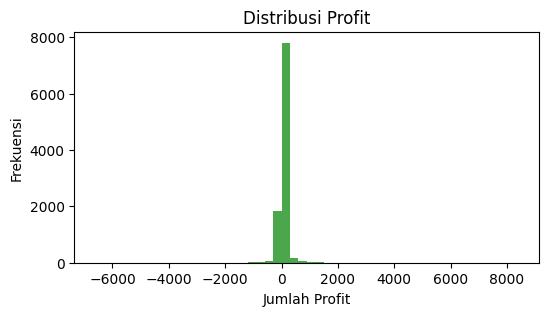

In [18]:
# Distribusi profit
plt.figure(figsize=(6, 3))
plt.hist(df['Profit'], bins=50, alpha=0.7, color='green')
plt.title('Distribusi Profit')
plt.xlabel('Jumlah Profit')
plt.ylabel('Frekuensi')
plt.show()

Berdasarkan diagram profit juga menunjukkan hal yang serupa seperti penjualan, namun terdapat nilai negatif ini bisa menunjukkan kerugian perusahaan tapi perlu dianalisis lebih lanjut yang akan kita lakukan pada tahap selanjutnya.

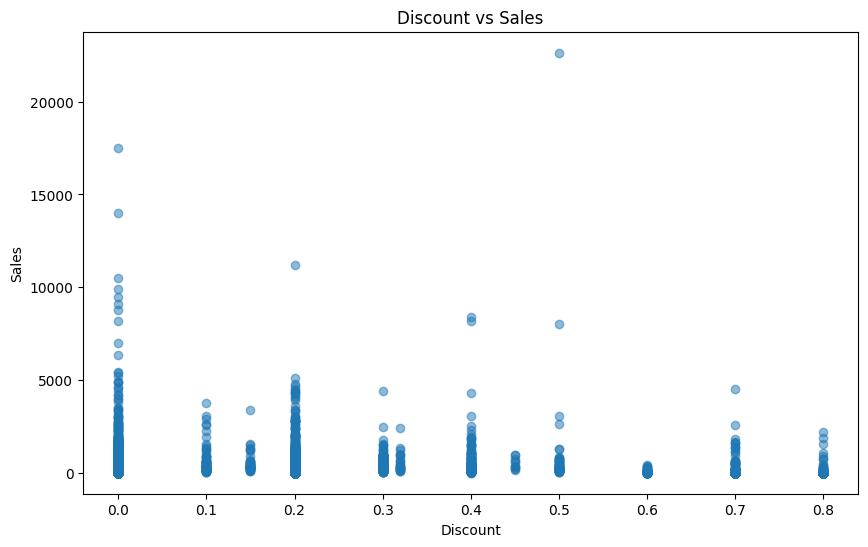

In [19]:
# Hubungan antara diskon dan sales
plt.figure(figsize=(10, 6))
plt.scatter(df['Discount'], df['Sales'], alpha=0.5)
plt.title('Discount vs Sales')
plt.xlabel('Discount')
plt.ylabel('Sales')
plt.show()

- **Sebaran Data:** Data sales tersebar cukup luas pada berbagai besaran diskon. Sebagian besar sales terjadi pada diskon kecil <= 0.2.
- **Konsentrasi Penjualan:** Ada konsentrasi sales yang tinggi pada diskon 0.0. Ini menunjukkan bahwa banyak sales terjadi tanpa memberikan diskon sama sekali.
- **Penjualan Tertinggi:** Sales tertinggi terjadi pada transaksi tanpa diskon atau diskon 0.0. Hal ini menunjukkan bahwa ada transaksi besar yang tidak memerlukan diskon besar.
- **Penjualan dengan Diskon Tinggi:** Sales pada diskon yang besar diatas 0.5 tampaknya lebih sedikit dan tidak ada sales dengan jumlah sangat besar pada besaran diskon yang lebih tinggi ini.
- **Efektivitas Diskon:** Diskon tidak selalu berhubungan langsung dengan peningkatan sales. Ada banyak sales dengan diskon kecil, dan sedikit sales besar dengan diskon besar.

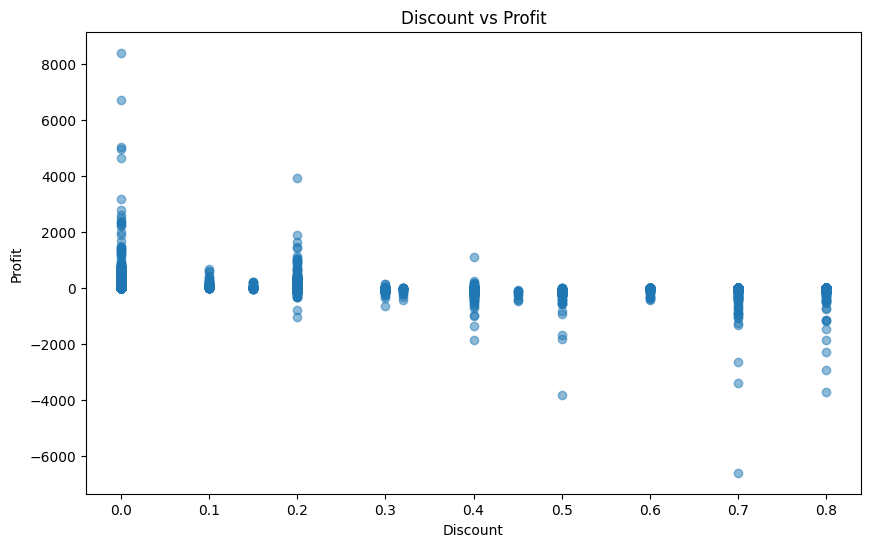

In [20]:
# Hubungan antara diskon dan profit
plt.figure(figsize=(10, 6))
plt.scatter(df['Discount'], df['Profit'], alpha=0.5)
plt.title('Discount vs Profit')
plt.xlabel('Discount')
plt.ylabel('Profit')
plt.show()

- **Sebaran Data:** Data profit tersebar cukup luas pada berbagai besaran diskon. Sebagian besar profit berada di diskon <= 0.2.
- **Profit Tertinggi:** Profit tertinggi terjadi pada tanpa diskon atau diskon 0.0. Ini menunjukkan bahwa sales tanpa diskon atau dengan diskon kecil lebih menguntungkan.
- **Kerugian pada diskon Tinggi:** Pada tingkat diskon yang besar diatas 0.5, terlihat adanya banyak titik yang berada disumbu vertikal negatif menunjukkan kerugian. Hal ini menunjukkan bahwa memberikan diskon tinggi cenderung mengurangi profit atau bahkan menyebabkan rugi.
- **Profit stabil pada diskon Rendah:** Pada diskon kecil < 0.4, profit cenderung lebih stabil dan terdapat beberapa titik profit yang besar.
- **Variabilitas profit:** Terdapat variabilitas yang cukup besar pada profit untuk berbagai besaran diskon. Beberapa transaksi dengan diskon < 4.0 tetap menghasilkan kerugian, dan beberapa transaksi dengan diskon tinggi masih menghasilkan keuntungan kecil.

In [21]:
# Menampilkan total produk terjual dari yang paling laris
product_count = df.groupby('Product')['Order ID'].count()
product_count.rename('Total Terjual', inplace=True)
pd.DataFrame(product_count).sort_values('Total Terjual', ascending=False)

,Total Terjual
Product,
ContactMatcher,1842
Support,1560
FinanceHub,981
SaaS Connector Pack,957
Site Analytics,889
Marketing Suite - Gold,846
ChatBot Plugin,796
Data Smasher,775
OneView,466


Dapat dilihat mana saja produk dari yang paling laris terjual sampai kurang laris.

In [22]:
# Menampilkan penjualan disetiap segmen bisnis dari yang paling banyak terjual
segment_count = df.groupby('Segment')['Order ID'].count()
segment_count.rename('Total Segmen', inplace=True)
pd.DataFrame(segment_count).sort_values('Total Segmen', ascending=False)

,Total Segmen
Segment,
SMB,5191
Strategic,3020
Enterprise,1783


Kemudian tabel diatas menampilkan segmen bisnis yang paling menguntungkan sampai kurang menguntungkan berdasarkan total transaksi.

In [23]:
# Menampilkan total penjualan disetiap industri dari yang paling banyak terjual
industry_count = df.groupby('Industry')['Order ID'].count()
industry_count.rename('Total Industri', inplace=True)
pd.DataFrame(industry_count).sort_values('Total Industri', ascending=False)

,Total Industri
Industry,
Finance,2127
Energy,1316
Tech,1236
Manufacturing,1222
Healthcare,1049
Consumer Products,1021
Retail,972
Communications,593
Transportation,351


Tabel diatas menampilkan dari sisi industri dari yang paling menguntungkan sampai kurang menguntungkan berdasarkan total transaksi.

## Data Analysis

Pada tahap analisis secara umum kita akan melihat terlebih dahulu bagaimana kinerja sales dan profit perusahaan agar kita bisa memastikan bahwa pemberian diskon tidak malah membuat profit perusahaan tergerus, kemudian kita lihat bagaimana perilaku pelanggan dari waktu ke waktu berdasarkan transaksi mereka agar kita bisa tahu retensinya.

Setelah itu kita bisa mengidentifikasi segmen pelanggan menggunakan rentang interquartile dan melihat besaran diskon yang mereka gunakan. Informasi ini berguna misalnya pelanggan yang menggunakan diskon rendah atau tidak menggunakan diskon tetapi memiliki penjualan tinggi mungkin merupakan pelanggan yang sangat loyal atau memiliki kebutuhan besar akan cloud service perusahaan.

Jadi kita akan menganalisis lebih mendalam untuk memahami bagaimana berbagai besaran diskon mempengaruhi sales dan profit. Misalnya, apakah ada ambang batas diskon tertentu di mana sales meningkat tetapi tidak menyebabkan profit negatif, informasi ini bisa membantu perusahaan dalam merumuskan strategi diskon yang lebih tepat sasaran untuk mengoptimumkan sales dan profit, khususnya untuk segmen pelanggan yang berada di kategori sales medium dan low.

### Kinerja penjualan perusahaan secara umum

In [24]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Ambil sampel ulang data dengan frekuensi yang berbeda
df_yearly = df.resample('Y', on='Order Date').sum().reset_index()
df_quarterly = df.resample('Q', on='Order Date').sum().reset_index()
df_half_yearly = df.resample('6M', on='Order Date').sum().reset_index()
df_monthly = df.resample('M', on='Order Date').sum().reset_index()

def line_chart(kolom):
    # Inisialisasi figur untuk grafiknya
    fig = go.Figure()

    # Menambahkan data tahunan
    fig.add_trace(go.Scatter(x=df_yearly['Order Date'], y=df_yearly[kolom], mode='lines', name='Yearly'))

    # Menambahkan data kuartal
    fig.add_trace(go.Scatter(x=df_quarterly['Order Date'], y=df_quarterly[kolom], mode='lines', name='Quarterly', visible=False))

    # Menambahkan data semester
    fig.add_trace(go.Scatter(x=df_half_yearly['Order Date'], y=df_half_yearly[kolom], mode='lines', name='Half-Yearly', visible=False))

    # Menambahkan data bulanan
    fig.add_trace(go.Scatter(x=df_monthly['Order Date'], y=df_monthly[kolom], mode='lines', name='Monthly', visible=False))

    # Membuat layout grafik
    fig.update_layout(
        updatemenus=[
            dict(
                buttons=list([
                    dict(
                        args=[{"visible": [True, False, False, False]}],
                        label="Tahunan",
                        method="update"
                    ),
                    dict(
                        args=[{"visible": [False, True, False, False]}],
                        label="Kuartal",
                        method="update"
                    ),
                    dict(
                        args=[{"visible": [False, False, True, False]}],
                        label="Semester",
                        method="update"
                    ),
                    dict(
                        args=[{"visible": [False, False, False, True]}],
                        label="Bulanan",
                        method="update"
                    )
                ]),
                direction="down",
                pad={"r": 10, "t": 10},
                showactive=True,
                x=0.17,
                xanchor="left",
                y=1.2,
                yanchor="top"
            ),
        ],
        width=1000,
        height=500
    )

    fig.update_xaxes(title_text='Date')
    fig.update_yaxes(title_text=kolom)
    fig.show()

# Menampilkan grafik garis sales
line_chart('Sales')

Berdasarkan diagram di atas dapat dilihat:
- Sales mulai meningkat tahun 2022 sampai 2023.
- Secara kuartal dan semester dari tahun 2020 sampai 2023 tren sales cenderung mengalami kenaikan.
- Secara bulanan dari tahun 2020 sampai 2023 tren sales stagnan.

Secara keseluruhan kinerja sales baik, selanjutnya kita lihat bagaimana kinerja profit.

In [25]:
# Menampilkan grafik garis profit
line_chart('Profit')

Berdasarkan diagram profit di atas dapat dilihat:
- Secara tahunan dari tahun 2020 sampai 2023 tren profit konsisten naik.
- Secara kuartal dari tahun 2020 sampai pertengahan 2022 tren profit cenderung stagnan.
- Secara semester dari tahun 2020 sampai 2023 tren profit cenderung mengalami kenaikan.
- Secara bulanan dari tahun 2020 sampai 2023 tren profit juga cenderung stagnan.
- Stagnan kemungkinan disebabkan profit kecil atau negatif.

Secara umum profit memang terus naik, namun jika dilihat periode waktu yang lebih kecil seperti perkuartal dan bulanan mengalami stagnan hal ini mungkin terjadi akibat profit kecil atau negatif akibat diskon tetapi ini bukan informasi yang buruk karena memang model bisnis perusahaan dalam mempertahankan pelanggan dan mendorong lebih banyak penggunaan _cloud service_ perusahaan. Jadi secara umum strategi diskon ini memang berhasil, sekarang untuk mengoptimumkan profit kita butuh mengetahui ambang batas diskon yang ideal bisa meningkatkan sales tetapi minimal tidak menyebabkan profit negatif.

In [26]:
# Menghitung rasio kerugian
print((df['Profit'] < 0).sum())
print(len(df['Profit']))
loss_ratio = (df['Profit'] < 0).sum() / len(df['Profit'])
print(f"Rasio Transaksi Kerugian: {loss_ratio:.2%}")

1871
9994
Rasio Transaksi Kerugian: 18.72%


Jika dilihat secara rasio kerugian yang dihitung dari total profit negatif dibagi jumlah data profit sebesar **18.72%**, maka untuk mengoptimumkan profit kita perlu terapkan strategi diskon yang ideal. Sekarang lebih jauh lagi kita cari tahu hitung-hitungan profit, berapa sebenarnya biaya produksi produk, dalam industri perusahaan AWS bisa mengacu kepada pemeliharan server _cloud_, sehingga kita bisa lihat dari revenue yang didapat setelah dipotong diskon lalu dikurang total biaya produksi berapa profitnya.

In [27]:
# Menghitung biaya per unit service
df['Revenue'] = df['Sales'] * (1 - df['Discount'])
df['Total Cost'] = df['Revenue'] - df['Profit']
df['Cost per Unit'] = df['Total Cost'] / df['Quantity']
df[['Order ID', 'Order Date', 'Customer', 'Industry', 'Segment', 'Product', 'Sales',
    'Quantity', 'Discount', 'Profit', 'Revenue', 'Total Cost', 'Cost per Unit']].sort_values('Profit').head(10)

,Order ID,Order Date,Customer,Industry,Segment,Product,Sales,Quantity,Discount,Profit,Revenue,Total Cost,Cost per Unit
7772,AMER-2022-108196,2022-11-26,Allstate,Finance,SMB,Big Ol Database,4499.985,5,0.7,-6599.9780,1349.9955,7949.9735,1589.9947
683,EMEA-2023-168116,2023-11-05,Costco Wholesale,Retail,Strategic,Big Ol Database,7999.980,4,0.5,-3839.9904,3999.9900,7839.9804,1959.9951
9774,APJ-2020-169019,2020-07-26,Bosch,Tech,SMB,ContactMatcher,2177.584,8,0.8,-3701.8928,435.5168,4137.4096,517.1762
3011,EMEA-2023-134845,2023-04-18,FedEx,Transportation,Enterprise,Big Ol Database,2549.985,5,0.7,-3399.9800,764.9955,4164.9755,832.9951
4991,APJ-2023-122714,2023-12-08,Ford Motor,Manufacturing,Strategic,ContactMatcher,1889.990,5,0.8,-2929.4845,377.9980,3307.4825,661.4965
3151,AMER-2021-147830,2021-12-15,Walgreens,Retail,SMB,Big Ol Database,1799.994,2,0.7,-2639.9912,539.9982,3179.9894,1589.9947
5310,APJ-2023-131254,2023-11-20,Itochu,Finance,SMB,ContactMatcher,1525.188,6,0.8,-2287.7820,305.0376,2592.8196,432.1366
9639,EMEA-2021-116638,2021-01-28,Morgan Stanley,Finance,SMB,ContactMatcher,4297.644,13,0.4,-1862.3124,2578.5864,4440.8988,341.6076
1199,APJ-2022-130946,2022-04-09,Volkswagen,Manufacturing,SMB,ContactMatcher,1088.792,4,0.8,-1850.9464,217.7584,2068.7048,517.1762
2697,EMEA-2020-145317,2020-03-18,Anthem,Healthcare,Enterprise,Big Ol Database,22638.480,6,0.5,-1811.0784,11319.2400,13130.3184,2188.3864


Dapat dilihat dari tabel diatas, sekarang coba kita analisa baris pertamanya:

> Biaya per unit untuk produk ini adalah **1589.9947**
>
> Dengan diskon **70%**
>
> Revenue yang didapat **1349.9955**
>
> Tetapi karena Total Cost adalah **7949.9735**, sehingga dengan menggunakan formula `Profit = Revenue − Total Cost`.
>
> Dimana Profit =  **1349.9955** - **7949.9735** = **-6599.9780**
>
> Sehingga transaksi pada ID pemesanan **AMER-2022-108196** di waktu 2022-11-26 menghasilkan Profit negatif sebesar **-6599.9780**

Ternyata diskon yang besar yang menyebabkan pendapatan negatif, sekarang coba kita lihat dari sisi korelasi dari Sales sampai Cost per Unit mana saja yang paling saling mempengaruhi.

<Axes: >

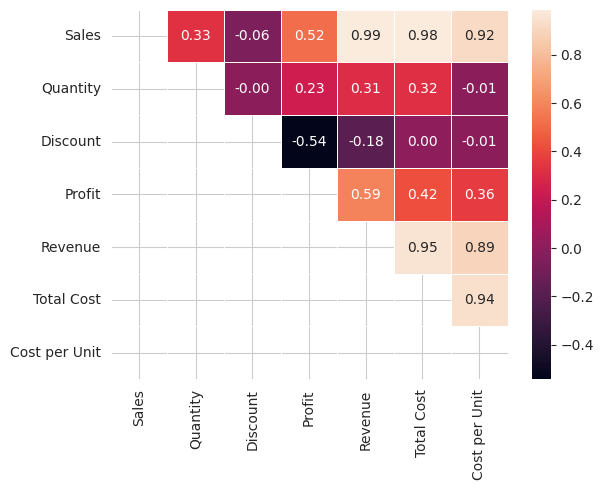

In [28]:
import seaborn as sns

# Menggunakan metode korelasi spearman karena distribusi data yang tidak normal
matrix_corr = df.loc[:, 'Sales': 'Cost per Unit'].corr(method='spearman')
mask = np.tril(np.ones_like(matrix_corr, dtype=bool)) # Membuat matriks dengan ukuran yang sama seperti matrix_corr, lalu mengubah menjadi boolean terutama diagonal atas diubah menjadi False
sns.set_style("whitegrid", {'axes.grid': True}) # Menambahkan grid
sns.heatmap(matrix_corr, mask=mask, annot=True, linewidth=.5, fmt='.2f') # Gunakan parameter mask untuk masking diagonal yang True

Korelasi diatas menunjukkan memang terdapat asosiasi:
- Asosiasi yang sedang ada antara diskon dengan profit dan revenue dengan arah korelasi negatif, masing-masing sebesar -0.54 dan -0.18.
- Asosiasi yang sedang antara diskon dan profit dengan arah negatif artinya ketika diskon meningkat maka profit cenderung menurun.
- Begitu juga asosiasi yang walaupun lemah antara diskon dengan revenue tetapi mengindikasikan bahwa ketika diskon meningkat makan revenue cenderung menurun.
- Selanjutnya ada juga korelasi dengan arah positif yang kuat antara sales dengan revenue, total cost, dan cost per unit yang masing-masing 0.99, 0.98, 0.92. Artinya kenaikan dari salah satunya akan dipengaruhi kenaikan lainnya.
- Kemudian antara revenue dengan total cost dan cost per unit juga memiliki korelasi positif kuat yang masing-masing 0.95 dan 0.89.

Sekarang kita lihat bagaimana tren pemberian diskon perusahaan apakah ada pola yang bisa dilihat.

### Tren pemberian diskon dari waktu ke waktu

In [29]:
import plotly.express as px

df_discount_count = df[df['Discount'] > 0.0]

# Menghitung total diskon setiap bulannya
discount_per_month = df_discount_count.groupby(df_discount_count['Order Date'].dt.to_period('m'))['Discount'].count().reset_index() # Mengelompokan jumlah diskon berdasarkan bulan
discount_per_month['Order Date'] = discount_per_month['Order Date'].astype(str)
discount_per_month['Order Date'] = pd.to_datetime(discount_per_month['Order Date'])
discount_per_month['Year'] = discount_per_month['Order Date'].dt.year

# Menghitung total diskon perjumlah diskon yang diberikan setiap bulannya
discount_amount_per_month = df_discount_count.groupby(df_discount_count['Order Date'].dt.to_period('m'))['Discount'].value_counts().reset_index() # Mengelompokan setiap diskon yang diberikan perbulannya lalu dihitung jumlah perdiskon
discount_amount_per_month[['Order Date', 'Discount']] = discount_amount_per_month[['Order Date', 'Discount']].astype(str)
discount_amount_per_month['Order Date'] = pd.to_datetime(discount_amount_per_month['Order Date'])
discount_amount_per_month['Year'] = discount_amount_per_month['Order Date'].dt.year

# Total diskon setiap bulannya
fig1 = px.line(discount_per_month, x="Order Date", y="Discount", title='Tren Diskon Perbulan')

# Menambahkan dropdown untuk memilih tahun
fig1.update_layout(
    updatemenus=[
        {
            "buttons": [
                {
                    "args": [{"x": [discount_per_month[discount_per_month['Year'] == year]['Order Date']],
                              "y": [discount_per_month[discount_per_month['Year'] == year]['Discount']],
                              "title": f'Tren Diskon Perbulan - {year}'}],
                    "label": str(year),
                    "method": "update",
                }
                for year in sorted(discount_per_month['Year'].unique())
            ],
            "direction": "down",
            "pad": {"r": 10, "t": 10},
            "showactive": True,
        }
    ],
    xaxis_title="Date",
    width=1000,
    height=500
)

fig1.show()

Secara tahunan pemberian diskon paling banyak pada bulan September dan November, di negara Amerika memang ada momen pada kedua bulan tersebut.
- Dibulan September bertepatan dengan musim gugur, perusahaan sering memberikan diskon untuk menarik perhatian konsumen baru dan memancing pelanggan lama berbelanja.
- Dibulan November adalah momen Black Friday yaitu hari Jumat setelah peringatan Thanksgiving di Amerika, dimana toko-toko memberikan diskon besar selama 24 jam dalam upaya untuk menarik konsumen berbelanja hadiah Natal dan tahun baru.

Kita akan lihat bagaimana retensi pelanggan kedua bulan tersebut.

In [30]:
# Total diskon perjumlah diskon yang diberikan setiap bulannya
def discount_amount_year(year):
    fig2 = px.line(discount_amount_per_month[discount_amount_per_month['Year'] == year],
                   x="Order Date", y="count", color='Discount', title='Tren Diskon Perbulan')
    fig2.update_layout(xaxis_title="Year", width=1000, height=500)
    fig2.show()

discount_amount_year(2020)
discount_amount_year(2021)
discount_amount_year(2022)
discount_amount_year(2023)

Jika dilihat tren pemberian diskon pada setiap besaran diskon sesuai dengan informasi yang kita dapatkan pada visualisasi scatterplot sebelumnya, pemberian diskon paling banyak 20% karena memang angka ini adalah angka yang umum perusahaan gunakan dalam memberikan diskon. Beberapa alasannya adalah:
- Persepsi nilai Diskon 20% dianggap cukup besar oleh konsumen sehingga mereka merasa mendapatkan nilai lebih dari pembelian mereka, tapi dari sisi perusahaan tidak mengorbankan terlalu banyak margin keuntungan bagi penjual.
- Keseimbangan antara daya tarik dan keuntungan dalam menarik minat pelanggan dan tetap mempertahankan profitabilitas bagi perusahaan. Diskon yang lebih tinggi mungkin menarik lebih banyak perhatian, tetapi juga dapat merugikan margin keuntungan.
- Strategi pemasaran yang umum banyak menggunakan angka ini karena sudah terbukti efektif dimana pelanggan sudah terbiasa melihat dan merespons diskon 20%.
- Efisiensi komunikasi angka 20% mudah untuk dikomunikasikan dan dipahami dalam materi promosi, seperti iklan, banner, dan email. Ini membantu dalam menarik perhatian cepat dan membuat pesan promosi lebih efisien.
- Penjualan impulsif, diskon 20% seringkali cukup untuk mendorong pembelian impulsif, di mana pelanggan merasa bahwa mereka mendapatkan keuntungan yang cukup besar sehingga mereka lebih cenderung melakukan pembelian tanpa terlalu banyak berpikir atau membandingkan dengan penawaran lain.

Walaupun diskon sebesar 20% menunjukkan keberhasilannya baik secara domain knowledge maupun data yang sebelumnya kita lihat grafiknya, tapi kita belum bisa ambil kesimpulan 20% adalah besaran diskon yang ideal, karena sesuai dengan tujuan analisis ini kita ingin mengidentifikasi segmen pelanggan yang menghasilkan sales high, medium, dan low. Dari segmen pelanggan sales high kita lihat besaran dan frekuensi diskon yang mereka gunakan sehingga kita bisa mengetahui besaran diskon yang ideal untuk mengoptimumkan sales dan profit.

### Analisis retensi pelanggan

Setelah mendapatkan gambaran bagaimana kinerja sales dan profit perusahaan secara keseluruhan, kita juga menambahkan fitur baru untuk memperkaya analisis kita yaitu revenue dan cost produksi produk sehingga kita bisa tahu angkanya bagaimana diskon menurunkan pendapatan perusahaan karena ternyata cost produksi produk yang tinggi, dalam konteks bisnis ini cost produksi berupa biaya pemeliharaan server.

Kita juga menganalisa korelasi antara sales, discount, revenue, profit, dan cost produk bahwa diskon memiliki korelasi sedang dengan arah negatif hal ini membuktikan bahwa diskon memiliki pengaruh berbanding kebalik dengan revenue dan profit. Sementara korelasi sales, revenue, dan cost produksi produk memiliki korelasi kuat dengan arah positif yang artinya mempengaruhi dengan arah yang sama naik atau turun. Ini sesuai dengan hukum ekonomi bahwa biaya produksi barang mempengaruhi harga jual barang.

Terakhir kita menelusuri secara mendalam pola pemberian diskon bahwa diskon paling banyak diberikan pada saat momen hari libur di Amerika dan besaran diskon 20% paling banyak digunakan.

Sekarang kita akan menganalisis kohort untuk mendapatkan wawasan tentang perilaku kelompok pelanggan yang berbeda dan perubahan perilaku belanja mereka dari waktu ke waktu, sehingga kita bisa mendapatkan gambaran loyalitas pelanggan secara keseluruhan. Sebelumnya kita sudah mengetahui semua pelanggan dari dataset ini melakukan transaksi dari tahun 2020, jadi kita akan membuat segmentasi pelanggan menjadi tiga segmen berdasarkan bulan pelanggan pertama kali melakukan transaksi kemudian dikelompokkan ke segmen kuartal dimana pelanggan pertama bertransaksi. Kita buat segmen tiga kuartal tahun 2020, tujuannya agar lebih mudah dibaca.

Text(0.5, 1.0, 'Retensi Pelanggan Bulanan Dari Tahun ke Tahun')

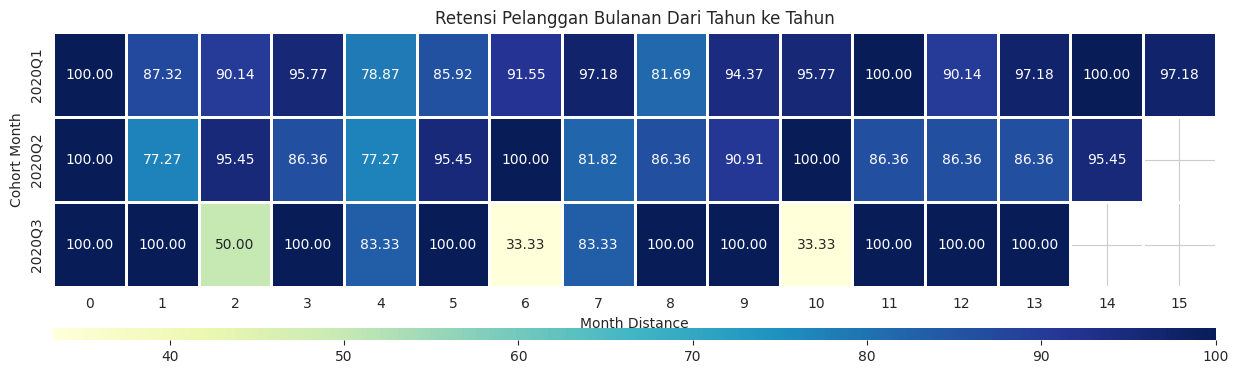

In [37]:
from datetime import datetime
from operator import attrgetter

# Membuat dataframe baru berisi waktu transaksi yang diambil dari order date dan customer ID
df_cohort = df[['Order Date', 'Customer ID']]

# Mengambil transaksi pertama pelanggan
cohort_date = df_cohort.groupby('Customer ID')['Order Date'].transform('min')

# Menggabungkan semua data transaksi pelanggan dengan transaksi pertama pelanggan
df_cohort['Cohort Quarter'] = cohort_date

# Ubah cohort month menjadi bulan agar bisa dilihat bulan apa pelanggan pertama kali melakukan transaksi
df_cohort['Cohort Quarter'] = df_cohort['Cohort Quarter'].dt.to_period('Q')

# Buat kolom baru berisi bulan apa saja user melakukan transaksi
df_cohort['Cohort Order Quarter'] = df_cohort['Order Date'].dt.to_period('Q')

# Menghitung total setiap pelanggan berdasarkan bulan pertama kali dia melakukan transaksi dan transaksi dibulan setelahnya
df_cohort_agg = pd.DataFrame(df_cohort.groupby(['Cohort Quarter', 'Cohort Order Quarter'])['Customer ID'].nunique())
df_cohort_agg = df_cohort_agg.reset_index()
df_cohort_agg = df_cohort_agg.rename(columns={'Customer ID': 'n_customer'})
df_cohort_agg = df_cohort_agg.sort_values(['Cohort Quarter', 'Cohort Order Quarter'])

# Menghitung berapa hari pelanggan sejak transaksi pertama
df_cohort_agg['Period Number'] = df_cohort_agg['Cohort Order Quarter'] - df_cohort_agg['Cohort Quarter']

# Mengambil angka jumlah dari perhitungan sebelumnya
df_cohort_agg['Period Number'] = df_cohort_agg['Period Number'].apply(lambda bulan: bulan.n)

# Membuat ringkasan data menggunakan pivot
df_cohort_pivot = df_cohort_agg.pivot_table(
    index='Cohort Quarter',
    columns='Period Number',
    values='n_customer'
)

# Mengubah jumlah cohort menjadi presentase
df_cohort_percent = (df_cohort_pivot.div(df_cohort_pivot[0], axis=0) * 100).round(2)

grid_kw = {
    'height_ratios': (20,1),        # perbandingan tinggi subplot
    'hspace': 0.3                   # jarak antar subplot
}

fig, (ax_top, ax_bottom) = plt.subplots(nrows=2, ncols=1, figsize=(15,4), gridspec_kw=grid_kw)

sns.heatmap(
    data= df_cohort_percent,
    ax= ax_top,                                 # axis dari heatmap
    cbar_ax= ax_bottom,                         # axis dari color bar
    cbar_kws= {'orientation':'horizontal'},     # customize color bar
    annot= True,                                # menampilkan label/anotasi
    fmt= '.2f',                                 # format anotasi 2 digit decimal
    cmap= 'YlGnBu',                             # palette warna
    linewidths= 2                               # border antar cell
)

ax_top.set_xlabel('Month Distance')
ax_top.set_ylabel('Cohort Month')
ax_top.set_title('Retensi Pelanggan Bulanan Dari Tahun ke Tahun')

Heatmap diatas adalah adalah presentase dari setiap kelompok pelanggan yang melakukan transaksi sepanjang bulan dari tahun ke tahun, pelanggan disegmentasikan ke dalam tiga kelompok yaitu 2020Q1, 2020Q2, dan 2020Q3. Cara membaca heatmap diatas dimulai dari sumbu X atau horizontal yang mewakili bulan dari bulan 0 yaitu bulan Januari sampai Desember tapi masih lanjut sampai bulan April tahun selanjutnya.

Karena periode waktu dataset ini selama 4 tahun lalu dibagi menjadi 3 (kelompok pelanggan berdasarkan kuartal) jika ditotalkan 48 bulan, jadi kita bisa baca sumbu Y atau vertikal yang dimulai dari X = 0 total kelompok pelanggan 100%, dibulan selanjutnya yaitu X = 1, X = 2, ..., X = 15 presentase pelanggan yang melakukan transaksi dibulan itu mulai naik turun dari total satu kelompok, yang berarti hanya sekian persen pelanggan didalam kelompok tersebut yang bertransaksi pada bulan tersebut.

Dapat dilihat bahwa secara umum retensi pelanggan terjaga, pelanggan yang sudah melakukan transaksi sejak tahun 2020 masih bertransaksi sampai akhir tahun 2023.

### Analisis Discount, Sales, dan Profit

Setelah mendapatkan wawasan secara umum tentang kinerja sales, profit, dan retensi pelanggan kita sudah tahu bahwa pemberian diskon tidak malah membuat keuntungan perusahaan tergerus secara signifikan dan bisa menjaga loyalitas pelanggan. Sekarang kita akan mengidentifikasi pelanggan yang telah menghasilkan sales high, medium, dan low berdasarkan distribusi total penjualan yang dibagi menggunakan rentang interquartile.

Kuartil dibawah 25% masuk kedalam segmen low sales, kuartil antara 25% - 75% masuk kedalam segmen medium sales, dan kuartil diatas 75% masuk kedalam high sales. Kemudian kita menganalisis bagaimana berbagai besaran diskon mempengaruhi penjualan dan profit di setiap segmen pelanggan untuk mencari ambang batas diskon yang ideal untuk mengoptimumkan sales dan profit.

Untuk menemukan ambang diskon yang ideal kita akan membagi data diskon ke dalam interval dan melihat rata-rata penjualan dan keuntungan pada setiap interval tersebut.

Untuk mencapai semua tujuan ini kita akan membuat agregasi data yang berisi setiap data pelanggan dengan informasi transaksi pertama dan terakhir, total transaksi, total pembelian, total sales, total profit, rata-rata diskon, dan sudah berapa lama jadi pelanggan.

In [38]:
# Menghitung tanggal transaksi pertama, terakhir, total transaksi, jumlah penggunaan diskon, dan profitabilitas per pelanggan
customer_analysis = df.groupby('Customer').agg(
    first_purchase=('Order Date', 'min'),
    last_purchase=('Order Date', 'max'),
    total_transactions=('Order ID', 'count'),
    total_quantity=('Quantity', 'sum'),
    total_sales=('Sales', 'sum'),
    total_profit=('Profit', 'sum'),
    discount_usage=('Discount', lambda x: (x > 0.0).mean())
).reset_index()

# Menambahkan kolom durasi pelanggan (tahun dan bulan)
customer_analysis['years_since_first_purchase'] = (pd.to_datetime('today') - customer_analysis['first_purchase']).dt.days // 365
customer_analysis['months_since_first_purchase'] = ((pd.to_datetime('today') - customer_analysis['first_purchase']).dt.days % 365) // 30

# Menggabungkan informasi tahun dan bulan menjadi satu kolom durasi
customer_analysis['duration'] = customer_analysis.apply(
    lambda row: f"{row['years_since_first_purchase']} years, {row['months_since_first_purchase']} months", axis=1
)

customer_analysis['first_purchase'] = customer_analysis['first_purchase'].dt.strftime('%Y-%m-%d')
customer_analysis['last_purchase'] = customer_analysis['last_purchase'].dt.strftime('%Y-%m-%d')

# Menampilkan tabel dengan kolom yang diinginkan
customer_analysis = customer_analysis[['Customer', 'first_purchase', 'last_purchase', 'total_transactions', 'total_quantity', 'total_sales', 'total_profit', 'discount_usage', 'duration']]

# Urutkan nilai
customer_analysis = customer_analysis.sort_values(['duration', 'total_sales', 'total_profit', 'discount_usage', 'total_quantity', 'total_transactions'], ascending=False)

# Membuat tabel menggunakan Plotly
fig3 = go.Figure(data=[go.Table(
    header=dict(values=list(customer_analysis.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[customer_analysis.Customer,
                       customer_analysis.first_purchase,
                       customer_analysis.last_purchase,
                       customer_analysis.total_transactions,
                       customer_analysis.total_quantity,
                       customer_analysis.total_sales,
                       customer_analysis.total_profit,
                       customer_analysis.discount_usage,
                       customer_analysis.duration],
               fill_color='lavender',
               align='left'))
])

fig3.update_layout(
    autosize=True,
    height=600
)

fig3.show()

Kita sudah mendapatkan informasi setiap pelanggan perusahaan, sekarang kita bisa kelompokkan pelanggan ke dalam interval sales high, medium, dan low menggunakan rentang interquertile.

In [43]:
# Membuat segmentasi pelanggan yang memiliki sales rendah, medium, dan tinggi berdasarkan kuartil
high_sales_threshold = customer_analysis['total_sales'].quantile(0.75)
low_sales_threshold = customer_analysis['total_sales'].quantile(0.25)
customer_analysis['Sales Segment'] = pd.cut(customer_analysis['total_sales'],
                                            bins=[-float('inf'), low_sales_threshold, high_sales_threshold, float('inf')],
                                            labels=['Low', 'Medium', 'High'])

customer_analysis.sort_values('total_sales', ascending=False)

,Customer,first_purchase,last_purchase,total_transactions,total_quantity,total_sales,total_profit,discount_usage,duration,Sales Segment
10,Anthem,2020-01-14,2023-12-24,134,523,55719.2100,5953.2038,0.432836,"5 years, 6 months",High
38,Ford Motor,2020-03-03,2023-12-25,176,672,43893.0424,4010.7662,0.482955,"5 years, 4 months",High
4,Allianz,2020-03-17,2023-12-30,192,709,42904.1670,5531.8834,0.526042,"5 years, 3 months",High
16,Bank of America Corp.,2020-06-15,2023-12-22,132,530,41255.9471,6449.8554,0.439394,"5 years, 0 months",High
92,Valero Energy,2020-03-18,2023-12-16,105,418,41220.4188,10308.6297,0.504762,"5 years, 3 months",High
...,...,...,...,...,...,...,...,...,...,...
86,Tesco,2020-08-05,2023-11-26,48,158,8173.2260,1689.7108,0.229167,"4 years, 11 months",Low
17,Berkshire Hathaway,2020-03-31,2023-12-27,39,119,7100.9290,812.7311,0.512821,"5 years, 3 months",Low
78,Safeway,2020-05-30,2023-10-16,39,158,6633.1370,472.4582,0.461538,"5 years, 1 months",Low
27,Citigroup,2020-04-25,2023-05-06,22,97,6132.5210,474.3321,0.545455,"5 years, 2 months",Low


Kita akan pecah data berdasarkan sales segment menjadi tabel terpisah agar kita memiliki data spesifik pelanggan yang sudah menghasilkan sales high, medium, dan low.

In [42]:
high_sales_segment = customer_analysis[customer_analysis['Sales Segment'] == 'High']
high_sales_segment = high_sales_segment.sort_values(['duration', 'total_sales', 'total_profit', 'discount_usage'], ascending=False)

high_sales_segment.sort_values('total_sales', ascending=False)

,Customer,first_purchase,last_purchase,total_transactions,total_quantity,total_sales,total_profit,discount_usage,duration,Sales Segment
10,Anthem,2020-01-14,2023-12-24,134,523,55719.2100,5953.2038,0.432836,"5 years, 6 months",High
38,Ford Motor,2020-03-03,2023-12-25,176,672,43893.0424,4010.7662,0.482955,"5 years, 4 months",High
4,Allianz,2020-03-17,2023-12-30,192,709,42904.1670,5531.8834,0.526042,"5 years, 3 months",High
16,Bank of America Corp.,2020-06-15,2023-12-22,132,530,41255.9471,6449.8554,0.439394,"5 years, 0 months",High
92,Valero Energy,2020-03-18,2023-12-16,105,418,41220.4188,10308.6297,0.504762,"5 years, 3 months",High
55,Lowes,2020-01-21,2023-12-24,110,439,40360.1630,7937.4915,0.527273,"5 years, 5 months",High
89,Tyson Foods,2020-03-21,2023-12-31,184,747,40326.3440,1690.5775,0.548913,"5 years, 3 months",High
5,Allstate,2020-02-19,2023-12-30,105,411,39941.6400,-2796.2935,0.380952,"5 years, 4 months",High
9,AmerisourceBergen,2020-02-24,2023-12-28,149,602,39234.7610,4202.8824,0.684564,"5 years, 4 months",High
13,BMW,2020-01-27,2023-11-18,111,426,39083.7900,5948.0993,0.549550,"5 years, 5 months",High


In [44]:
medium_sales_segment = customer_analysis[customer_analysis['Sales Segment'] == 'Medium']
medium_sales_segment = medium_sales_segment.sort_values(['duration', 'total_sales', 'total_profit', 'discount_usage'], ascending=False)

medium_sales_segment.sort_values('total_sales', ascending=False)

,Customer,first_purchase,last_purchase,total_transactions,total_quantity,total_sales,total_profit,discount_usage,duration,Sales Segment
97,Walt Disney,2020-04-02,2023-12-09,103,374,29483.0050,5786.8297,0.563107,"5 years, 3 months",Medium
0,AT&T,2020-03-11,2023-12-22,151,536,29462.3240,4520.6641,0.456954,"5 years, 4 months",Medium
28,Coca-Cola,2020-02-28,2023-12-22,81,305,28643.8040,9449.0246,0.530864,"5 years, 4 months",Medium
63,Morgan Stanley,2020-01-15,2023-12-31,126,484,28631.4500,-361.8099,0.523810,"5 years, 6 months",Medium
74,Phillips 66,2020-03-01,2023-12-19,86,326,27601.0180,5259.8958,0.453488,"5 years, 4 months",Medium
2,Aetna,2020-03-31,2023-12-10,153,608,27278.5930,3312.6698,0.542484,"5 years, 3 months",Medium
50,Intel,2020-03-01,2023-12-18,122,458,26970.7510,1725.5685,0.540984,"5 years, 4 months",Medium
36,Fannie Mae,2020-04-11,2023-12-24,102,412,25957.2570,4079.5869,0.519608,"5 years, 3 months",Medium
29,Comcast,2020-03-14,2023-12-29,161,564,25597.5700,2086.9055,0.590062,"5 years, 4 months",Medium
19,Bosch,2020-01-14,2023-12-09,119,474,25444.9990,-1823.7794,0.529412,"5 years, 6 months",Medium


In [45]:
low_sales_segment = customer_analysis[customer_analysis['Sales Segment'] == 'Low']
low_sales_segment = low_sales_segment.sort_values(['duration', 'total_sales', 'total_profit', 'discount_usage'], ascending=False)

low_sales_segment.sort_values('total_sales', ascending=False)

,Customer,first_purchase,last_purchase,total_transactions,total_quantity,total_sales,total_profit,discount_usage,duration,Sales Segment
42,Glencore,2020-03-28,2023-11-11,56,220,15649.1490,4470.1537,0.410714,"5 years, 3 months",Low
52,J.P. Morgan Chase & Co.,2020-05-18,2023-12-25,101,374,15451.0502,1752.5227,0.584158,"5 years, 1 months",Low
12,Aviva,2020-01-16,2023-12-31,100,345,14863.5270,1474.3551,0.380000,"5 years, 5 months",Low
58,McKesson,2020-05-05,2023-12-25,63,262,14431.0060,1750.2888,0.634921,"5 years, 2 months",Low
95,Walgreens,2020-02-12,2023-12-17,68,241,14420.6190,-740.6747,0.455882,"5 years, 5 months",Low
18,Boeing,2020-01-31,2023-12-27,90,301,14296.1480,666.5414,0.622222,"5 years, 5 months",Low
60,Microsoft,2020-09-19,2023-12-26,66,240,13444.0710,2501.4290,0.530303,"4 years, 9 months",Low
65,News Corp.,2020-04-06,2023-12-04,51,193,12942.6106,2693.4753,0.372549,"5 years, 3 months",Low
48,Huawei,2020-01-24,2023-10-17,56,197,12904.5314,1984.0901,0.625000,"5 years, 5 months",Low
69,Pemex,2020-01-20,2023-12-09,70,232,12864.3960,2194.2500,0.600000,"5 years, 5 months",Low


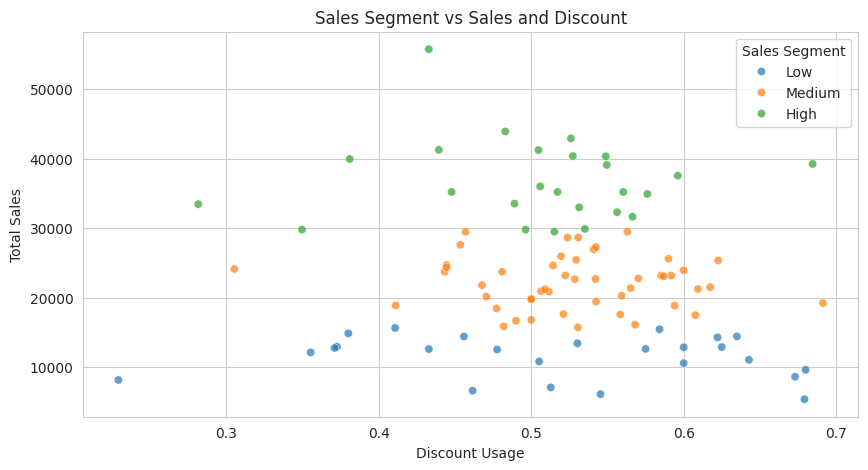

In [46]:
# Scatter plot Sales Segment vs Sales dan Discount
plt.figure(figsize=(10, 5))
sns.scatterplot(data=customer_analysis, x='discount_usage', y='total_sales', hue='Sales Segment', alpha=0.7)
plt.title('Sales Segment vs Sales and Discount')
plt.xlabel('Discount Usage')
plt.ylabel('Total Sales')
plt.show()

Scatterplot diatas kita dapat tarik kesimpulan:
- Pelanggan dalam segmen penjualan high memiliki penggunaan diskon yang bervariasi dari sekitar 0.3 hingga 0.6, dengan tendensi di sekitar 0.5.
- Pelanggan dalam segmen penjualan medium dan low juga memiliki penggunaan diskon yang bervariasi, tetapi cenderung lebih tinggi sekitar 0.4 hingga 0.6.

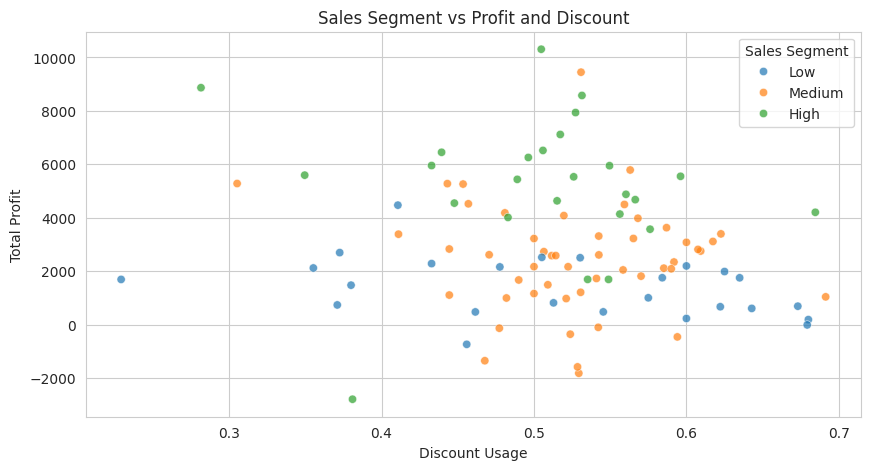

In [47]:
# Scatter plot Sales Segment vs Profit dan Discount
plt.figure(figsize=(10, 5))
sns.scatterplot(data=customer_analysis, x='discount_usage', y='total_profit', hue='Sales Segment', alpha=0.7)
plt.title('Sales Segment vs Profit and Discount')
plt.xlabel('Discount Usage')
plt.ylabel('Total Profit')
plt.show()

Scatterplot diatas kita dapat tarik kesimpulan:
- Pelanggan dengan profit tertinggi cenderung memiliki penggunaan diskon di sekitar 0.4 hingga 0.5. Diluar interval ini profit cenderung menurun.
- Beberapa pelanggan menyebabkan kerugian profit pada interval diskon yang hampir sama dari 0.4 sampai 0.6.

In [48]:
# Analisis rata-rata discount usage per sales segment
average_discount = customer_analysis.groupby('Sales Segment')['discount_usage'].mean().reset_index()
average_discount

,Sales Segment,discount_usage
0,Low,0.518270
1,Medium,0.527028
2,High,0.504075


Ternyata hampir tidak ada perbedaan rata-rata diskon yang digunakan pelanggan dari semua segmen, tapi berdasarkan analisa sebelumnya menunjukkan pemberian diskon dapat menjaga retensi pelanggan. Dan pada tabel tersebut juga terlihat rata-rata besaran diskon yang digunakan pelanggan disetiap segmen sebesar 5%, mungkin ini adalah ambang batas diskon yang ideal tapi kita perlu secara khusus analisis lagi, kita akan cari tahu ambang diskon yang ideal dengan membagi data diskon ke dalam interval dan melihat rata-rata penjualan dan keuntungan pada setiap interval tersebut.

In [49]:
# Analisis rata-rata sales dan profit per sales segment
average_sales_profit = customer_analysis.groupby('Sales Segment').agg({
    'total_sales': 'median',
    'total_profit': 'median'
}).reset_index()
average_sales_profit

,Sales Segment,total_sales,total_profit
0,Low,12617.1140,1474.3551
1,Medium,22650.8206,2581.9241
2,High,35201.6250,5531.8834


Pada scatterplot sebelumnya menunjukkan segmen pelanggan low dan medium memang cenderung menggunakan diskon yang lebih tinggi sehingga menurunkan profit. Sekarang kita lihat berapa ambang diskon yang ideal.

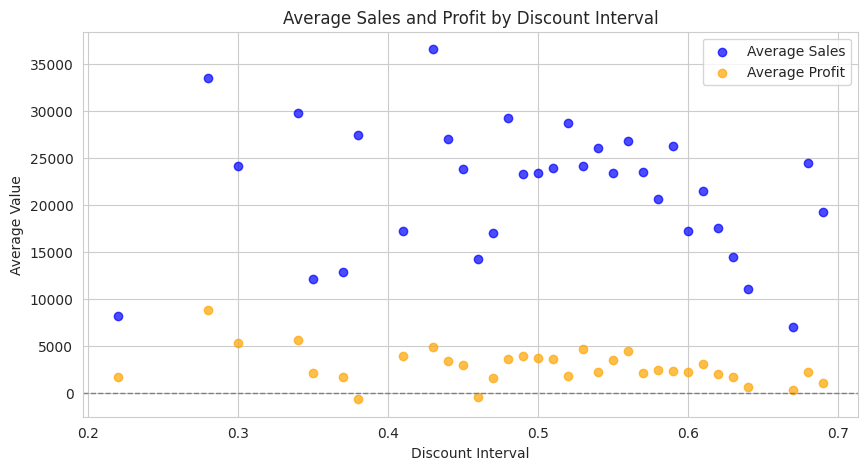

In [50]:
# Membuat interval discount
discount_intervals = np.arange(0, customer_analysis['discount_usage'].max() + 0.01, 0.01)
avg_sales = []
avg_profit = []

# Menghitung rata-rata sales dan profit untuk setiap interval discount
for interval in discount_intervals:
    temp_df = customer_analysis[(customer_analysis['discount_usage'] >= interval) & (customer_analysis['discount_usage'] < interval + 0.01)]
    avg_sales.append(temp_df['total_sales'].mean())
    avg_profit.append(temp_df['total_profit'].mean())

# Hasilnya dimasukkan ke dalam dataframe
discount_analysis = pd.DataFrame({
    'discount_interval': discount_intervals,
    'avg_sales': avg_sales,
    'avg_profit': avg_profit
})

# Tampilkan visualisasi menggunakan scatterplot
plt.figure(figsize=(10, 5))
plt.scatter(discount_analysis['discount_interval'], discount_analysis['avg_sales'], label='Average Sales', color='blue', alpha=0.7)
plt.scatter(discount_analysis['discount_interval'], discount_analysis['avg_profit'], label='Average Profit', color='orange', alpha=0.7)
plt.axhline(0, color='grey', linestyle='--', linewidth=1)
plt.title('Average Sales and Profit by Discount Interval')
plt.xlabel('Discount Interval')
plt.ylabel('Average Value')
plt.legend()
plt.show()

Dapat dilihat pada lineplot diatas diskon yang ideal berada di interval diskon 0.5 hingga 0.6 dimana sales masih cukup tinggi dan profit berada pada nilai positif.

## Insight

Dari analisis yang telah dilakukan, kita bisa membuat kesimpulan tentang merumuskan strategi diskon yang lebih tepat sasaran untuk mengoptimumkan sales dan profit, khususnya untuk segmen pelanggan yang berada di kategori sales medium dan low.

Dari analisis diatas interval diskon ideal di mana penjualan tinggi tetapi keuntungan tidak sampai negatif adalah antara 0.5 hingga 0.6. Pada interval ini, kita dapat melihat:
- Penjualan masih cukup tinggi.
- Keuntungan berada pada nilai positif atau tidak melewati batas nol.
Tetapi berdasarkan grafik scatterplot _Sales Segment vs Profit and Discount_ dan _Sales Segment vs Profit and Discount_, dan tabel _average discount_ **besaran diskon yang paling aman adalah 50%**.

Kita juga sudah mendapatkan data pelanggan perusahaan yang berada dikategori medium sales yang dapat dilihat pada tabel _medium sales segment_ dan kategori low sales yang dapat dilihat pada tabel _low sales segment_ sehingga perusahaan secara tepat sasaran bisa mengembangkan strategi diskon untuk kedua kelompok pelanggan tersebut yang dapat mengoptimumkan sales dengan memancing lagi pembelian mereka dan mengoptimumkan profit dengan mengurangi profit negatif.

## Recommendation

1. Maksimum pemberian diskon sebesar 50%. Diskon diatas nilai ini cenderung menurunkan keuntungan secara signifikan.
2. Berikan diskon secara berjenjang di mana pelanggan mendapatkan diskon yang lebih besar sampai batas maksimal 50% jika mereka memakai service cloud perusahaan sampai tingkat tertentu seperti model _Pay less by using more_ yang sudah diterapkan, atau ketika mereka menambah service tawarkan bundling produk seperti model _Bundled Discounts_ yang sudah diterapkan juga, sehingga mereka mendapatkan diskon jika menyewa beberapa service sekaligus. Kedua cara ini bisa memancing penambahan pembelian pelanggan.
3. Strategi dipersonalisasi berdasarkan segmen pelanggan.

Dengan rekomendasi ini, perusahaan dapat mendorong peningkatan penggunaan dan pembelian layanan tambahan dari pelanggan di segmen sales medium dan low, sambil menjaga keuntungan tetap positif dan mengoptimalkan strategi diskon.